# Assignment 1 — Colab Workflow (GitHub + Pre-commit + Submission Validation)

This notebook teaches the standard workflow used throughout the course:

1. Clone your team repo
2. Install dependencies
3. Install **pre-commit** and enable a hook to strip notebook outputs
4. Run this notebook end-to-end
5. Validate `predictions.csv`
6. Commit + push + tag


In [1]:
# (Colab) show python and system info
import sys, platform
print(sys.version)
print(platform.platform())


3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Linux-6.6.105+-x86_64-with-glibc2.35


## 1) Clone Repo

Login to your personal Github account, and make a fork of: https://github.com/TLKline/AIHC-5010-Winter-2026

Follow setup directions for working with a PAT in GitHub (30-second guide):

* Go to GitHub → Settings
* Developer settings
* Personal access tokens
* Choose:
  * Fine-Grained

You can clone using HTTPS.

Repo HTTPS URL (e.g., `https://github.com/TLKline/AIHC-5010-Winter-2026.git`)

In [2]:
# TODO: Change the following to your github repo path
repo_path = 'https://github.com/mppenfold/AIHC5010-Winter-2026.git'
!git clone {repo_path} student_repo

Cloning into 'student_repo'...
remote: Enumerating objects: 359, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 359 (delta 42), reused 39 (delta 32), pack-reused 302 (from 2)
Receiving objects: 100% (359/359), 10.36 MiB | 10.07 MiB/s, done.
Resolving deltas: 100% (168/168), done.


In [3]:
# Move into repo
%cd student_repo

# Repo git info
!git status

# Where are we?
print('----------')
print('We are at:')
!pwd


/content/student_repo
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
----------
We are at:
/content/student_repo


## 2) Install dependencies

This installs whatever is in `requirements.txt`.


In [4]:
!pip -q install -r Project-1/readmit30/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.4/226.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.5 MB/s eta 0:00:00


## 3) Enable pre-commit hook to strip notebook outputs

This prevents giant notebooks and reduces merge/diff pain.

One-time per clone:
- `pre-commit install`

After that, every `git commit` will strip outputs from `*.ipynb`.


In [5]:
!pip -q install pre-commit
!pre-commit install


pre-commit installed at .git/hooks/pre-commit


#MAINSTART

# 4) Submission Notebook (Template)

Replace the baseline model with your team’s approach.

In [6]:
import os
from pathlib import Path

TRAIN_PATH = os.environ.get("TRAIN_PATH", "Project-1/readmit30/scripts/data/public/train.csv")
DEV_PATH   = os.environ.get("DEV_PATH",   "Project-1/readmit30/scripts/data/public/dev.csv")
TEST_PATH  = os.environ.get("TEST_PATH",  "Project-1/readmit30/scripts/data/public/public_test.csv")
OUT_PATH   = os.environ.get("OUT_PATH",   "predictions.csv")

print("TRAIN_PATH:", TRAIN_PATH)
print("DEV_PATH:", DEV_PATH)
print("TEST_PATH:", TEST_PATH)
print("OUT_PATH:", OUT_PATH)

TRAIN_PATH: Project-1/readmit30/scripts/data/public/train.csv
DEV_PATH: Project-1/readmit30/scripts/data/public/dev.csv
TEST_PATH: Project-1/readmit30/scripts/data/public/public_test.csv
OUT_PATH: predictions.csv


In [7]:
import numpy as np
import pandas as pd
np.random.seed(42)

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

assert "row_id" in train.columns and "readmit30" in train.columns
assert "row_id" in test.columns

X_train = train.drop(columns=["readmit30"])
y_train = train["readmit30"].astype(int)

In [8]:
# EDA - 1 Basic Dataset Snapshot

# Rows x columns
n_rows, n_cols = train.shape

# Outcome column name and overall readmission rate
outcome_col = "readmit30"
readmit_rate = train[outcome_col].mean()

# Data types summary
cat_cols = [c for c in train.columns if train[c].dtype == "object"]
num_cols = [c for c in train.columns if c not in cat_cols]

# Printed output
print("Rows × Columns:", n_rows, "×", n_cols)
print(f"Outcome column name: {outcome_col}")
print(f"Overall readmission rate (mean of readmit30): {readmit_rate:.4f}")
print()
print("Number of numeric columns:", len(num_cols))
print("Number of categorical columns:", len(cat_cols))
print()
print("Preview of data (df.head()):")
train.head()

Rows × Columns: 65003 × 51
Outcome column name: readmit30
Overall readmission rate (mean of readmit30): 0.1116

Number of numeric columns: 15
Number of categorical columns: 36

Preview of data (df.head()):


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,row_id,readmit30
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,2278392,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,149190,0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,Steady,No,No,No,No,No,Ch,Yes,16680,0
3,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,Steady,No,No,No,No,No,No,Yes,35754,0
4,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,Yes,63768,0


In [9]:
# Look at categorical variables for possible missing values

for col in cat_cols:
    print(f"\nValue counts for {col}:")
    print(train[col].value_counts())


Value counts for race:
race
Caucasian          48447
AfricanAmerican    12381
?                   1471
Hispanic            1304
Other                984
Asian                416
Name: count, dtype: int64

Value counts for gender:
gender
Female             35011
Male               29990
Unknown/Invalid        2
Name: count, dtype: int64

Value counts for age:
age
[70-80)     16725
[60-70)     14550
[80-90)     10940
[50-60)     10832
[40-50)      6153
[30-40)      2453
[90-100)     1770
[20-30)      1034
[10-20)       438
[0-10)        108
Name: count, dtype: int64

Value counts for weight:
weight
?            63018
[75-100)       808
[50-75)        572
[100-125)      400
[125-150)       91
[25-50)         57
[0-25)          31
[150-175)       18
[175-200)        6
>200             2
Name: count, dtype: int64

Value counts for payer_code:
payer_code
?     25733
MC    20677
HM     4057
SP     3178
BC     2868
MD     2292
CP     1656
UN     1579
CM     1247
OG      671
PO      377
DM    

                          missing_count  missing_pct
weight                            63018    96.946295
max_glu_serum                     61584    94.740243
A1Cresult                         54211    83.397689
medical_specialty                 31809    48.934665
payer_code                        25733    39.587404
race                               1471     2.262972
diag_3                              904     1.390705
diag_2                              218     0.335369
diag_1                               13     0.019999
gender                                2     0.003077
encounter_id                          0     0.000000
patient_nbr                           0     0.000000
age                                   0     0.000000
admission_type_id                     0     0.000000
discharge_disposition_id              0     0.000000
admission_source_id                   0     0.000000
time_in_hospital                      0     0.000000
num_lab_procedures                    0     0.

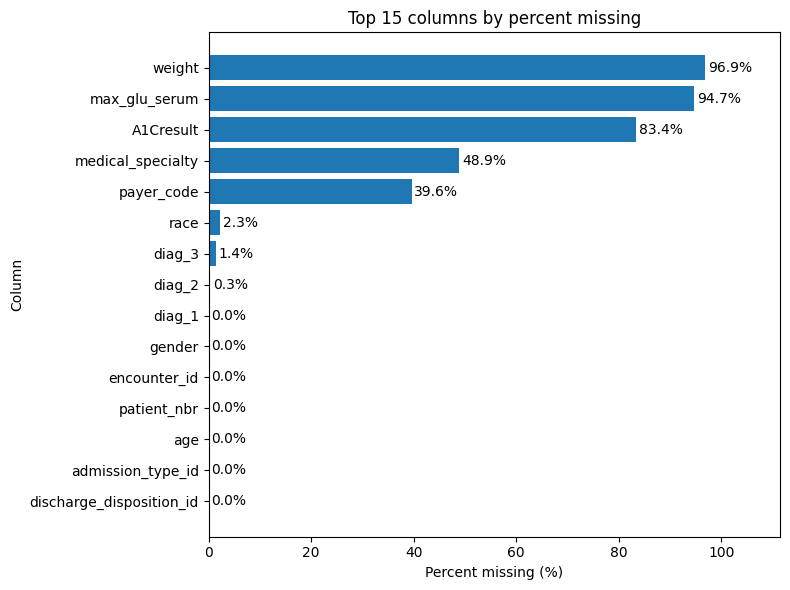

Variables With Acceptable Missingness

• Column name: diabetesMed, missing count: 0, missing pct: 0.00%
• Column name: insulin, missing count: 0, missing pct: 0.00%
• Column name: metformin, missing count: 0, missing pct: 0.00%

Variables With Problematic Missingness — Recommended Actions

• Column name: weight, missing count: 63,018, missing pct: 96.95%, reccomended action: Drop
• Column name: max_glu_serum, missing count: 61,584, missing pct: 94.74%, reccomended action: Drop
• Column name: A1Cresult, missing count: 54,211, missing pct: 83.40%, reccomended action: Drop


In [11]:
# EDA - 2 Missingness Audit

import matplotlib.pyplot as plt

# A table of missigness per coulmn including count missing and % missing, sorted high to low
# Change ? to missing value
train = train.replace("?", np.nan)
train = train.replace("Unknown/Invalid", np.nan)

# Total rows for percent calculation
n = len(train)

# Compute count and percent missing per column
missing_df = (
    train.isna()
         .sum()                               # count missing per column
         .to_frame(name="missing_count")
         .assign(missing_pct=lambda df: df["missing_count"] / n * 100)
         .sort_values(["missing_count", "missing_pct"], ascending=False)
)

# A bar plot of the top 15 columns by % missing
top15 = missing_df.head(15).iloc[::-1]

# Prepare plot
plt.figure(figsize=(8, 6))
bars = plt.barh(top15.index, top15["missing_pct"], color="#1f77b4")
plt.xlabel("Percent missing (%)")
plt.ylabel("Column")
plt.title("Top 15 columns by percent missing")
for bar, pct in zip(bars, top15["missing_pct"]):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f"{pct:.1f}%", va="center")
plt.xlim(0, max(5, top15["missing_pct"].max() * 1.15))
plt.tight_layout()

# A short list, 3 columns with acceptable missingness (<5%) and 3 columns with problematic missingness (>30%) and recommendation for action (drop vs impute vs investigate collection)
acceptable_cols = ["diabetesMed", "insulin", "metformin"]
problem_cols = ["weight", "max_glu_serum", "A1Cresult"]
action = ["Drop", "Drop", "Drop"]

# Printed output - table, plot, 6 bullet point recommendations
print(missing_df)
plt.show()
print("Variables With Acceptable Missingness\n")
for col in acceptable_cols:
    missing_count = missing_df.loc[col, "missing_count"]
    missing_pct = missing_df.loc[col, "missing_pct"]
    print(f"\u2022 Column name: {col}, missing count: {missing_count:,}, missing pct: {missing_pct:.2f}%")
print("\nVariables With Problematic Missingness — Recommended Actions\n")
for col in problem_cols:
    missing_count = missing_df.loc[col, "missing_count"]
    missing_pct = missing_df.loc[col, "missing_pct"]
    print(f"\u2022 Column name: {col}, missing count: {missing_count:,}, missing pct: {missing_pct:.2f}%, reccomended action: {action[problem_cols.index(col)]}")


In [17]:
# EDA - 3 Missingness Related to Outcome?

import math

# Create a binary indicator
for col in problem_cols:
    new_col = f"is_missing_{col}"
    train[new_col] = train[col].replace("?", np.nan).isna().astype(int)

# Create a two row table
rows = []

for col in problem_cols:
    indicator = f"is_missing_{col}"

    # mean(readmit30) gives readmission rate; multiply by 100 for %
    rate_not_missing = train.loc[train[indicator] == 0, "readmit30"].mean() * 100
    rate_missing     = train.loc[train[indicator] == 1, "readmit30"].mean() * 100

    rows.append({
        "variable": col,
        "not_missing_readmit_rate_pct": rate_not_missing,
        "missing_readmit_rate_pct": rate_missing
    })

readmit_missing_table = pd.DataFrame(rows)

# Round for display
readmit_missing_table = readmit_missing_table.round(2)


# Print output
print(readmit_missing_table)
print("Missingness for weight appears not associated with outcome.")
print("Missingness for max_glu_serum appears not associated with outcome.")
print("Missingness for A1Cresult appears possibly associated with outcome; potential MNAR/MAR implications.")


        variable  not_missing_readmit_rate_pct  missing_readmit_rate_pct
0         weight                         12.04                     11.13
1  max_glu_serum                         12.49                     11.09
2      A1Cresult                          9.73                     11.45
Missingness for weight appears not associated with outcome.
Missingness for max_glu_serum appears not associated with outcome.
Missingness for A1Cresult appears possibly associated with outcome; potential MNAR/MAR implications.


Number of duplicate rows (excluding the first occurrence): 0
Number of duplicate 'encounter_id's: 0
Number of duplicate 'patient_nbr's: 19232
Top repeated 'patient_nbr's:
patient_nbr
88785891    40
88227540    23
1660293     23
23643405    22
84428613    22
29903877    20
89472402    20
88789707    20
88681950    19
97391007    19
Name: count, dtype: int64

Summary of outliers for time_in_hospital, num_lab_procedures, and num_medications:
                    min  p01  median   p99    max
time_in_hospital    1.0  1.0     4.0  13.0   14.0
num_lab_procedures  1.0  1.0    44.0  85.0  129.0
num_medications     1.0  3.0    15.0  43.0   81.0

Histograms:


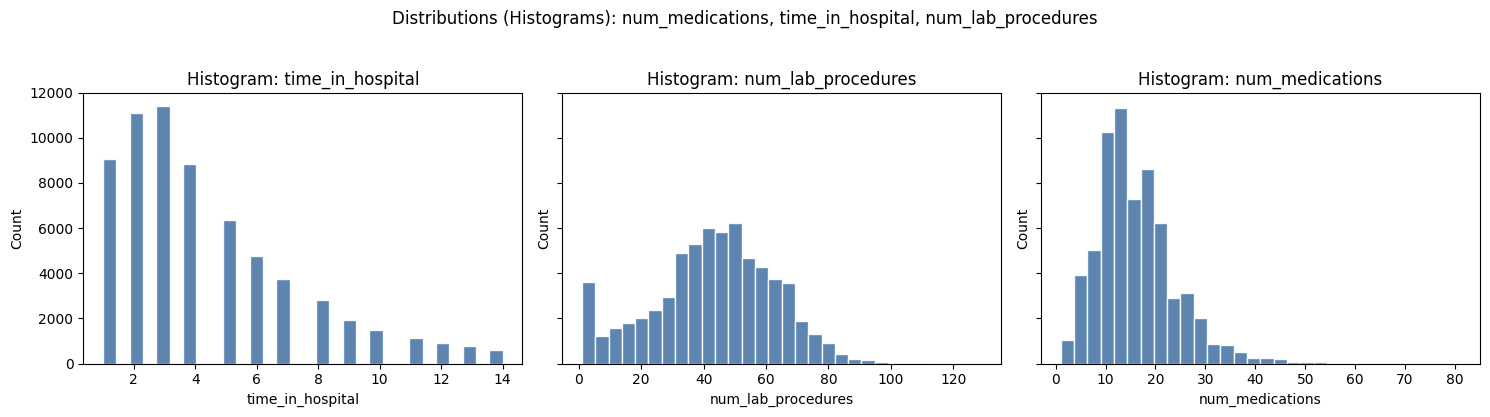


Leakage screen:
The column 'discharge_disposition_id' may be a leakage because it identifies what happened at the end of the admission, including possible discharge as deceased, which would affect readmission.
The column 'payer_code' may be a leakage because insurance does not pay until after discharge.


In [29]:
# EDA - 4 Minimal data quality checks

# Duplicate rows
# Boolean mask of rows that are duplicates of a *previous* row
dup_mask = train.duplicated(keep='first')
# Count of duplicated rows (excludes the first occurrence)
num_dups_excluding_first = dup_mask.sum()

# Duplicate encounter IDs
dup_id = train.duplicated(subset=['encounter_id'], keep='first')
num_dups_id = dup_id.sum()

# Duplicate patient numbers
dup_ptnum = train.duplicated(subset=['patient_nbr'], keep='first')
num_dups_ptnum = dup_ptnum.sum()

# Outliers/validity
outliers_cols = ["time_in_hospital", "num_lab_procedures", "num_medications"]
summary = train[outliers_cols].quantile([0.00, 0.01, 0.50, 0.99, 1.00]).T
summary.columns = ["min", "p01", "median", "p99", "max"]

# Histogram
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, col in zip(axes, outliers_cols):
    data = train[col].dropna()
    ax.hist(data, bins=30, color="#4C78A8", edgecolor="white", alpha=0.9)
    ax.set_title(f"Histogram: {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
fig.suptitle("Distributions (Histograms): num_medications, time_in_hospital, num_lab_procedures", y=1.03)
plt.tight_layout()

# Print Output
print(f"Number of duplicate rows (excluding the first occurrence): {num_dups_excluding_first}")
print(f"Number of duplicate 'encounter_id's: {num_dups_id}")
print(f"Number of duplicate 'patient_nbr's: {num_dups_ptnum}")
print(f"Top repeated 'patient_nbr's:")
print(train['patient_nbr'].value_counts().head(10))
print("\nSummary of outliers for time_in_hospital, num_lab_procedures, and num_medications:")
print(summary)
print("\nHistograms:")
plt.show()
print("\nLeakage screen:")
print("The column 'discharge_disposition_id' may be a leakage because it identifies what happened at the end of the admission, including possible discharge as deceased, which would affect readmission.")
print("The column 'payer_code' may be a leakage because insurance does not pay until after discharge.")


In [30]:
# Final EDA summary

print("Top 5 Missing Colyumns:")
print(missing_df.head(5))
print("\nMissingness for A1Cresult appears possibly associated with outcome.")
print("\nRecommended EDA-driven next steps:")
print("\u2022 Drop columns including: 'weight, max_glu_serum, and A1Cresult")
print("\u2022 Consolidate gender column 'Unknown/Invalid' into missingness data")
print("\u2022 Exclude discharge_disposition_id to exclude possible leakage")

Top 5 Missing Colyumns:
                   missing_count  missing_pct
weight                     63018    96.946295
max_glu_serum              61584    94.740243
A1Cresult                  54211    83.397689
medical_specialty          31809    48.934665
payer_code                 25733    39.587404

Missingness for A1Cresult appears possibly associated with outcome.

Recommended EDA-driven next steps:
• Drop columns including: 'weight, max_glu_serum, and A1Cresult
• Consolidate gender column 'Unknown/Invalid' into missingness data
• Exclude discharge_disposition_id to exclude possible leakage


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# TODO: Add any new imports for your own method here
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

method = 4

cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ],
)

if method==1:
    # Use logistic regression model
    clf = Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=200)),
    ])

if method==2:
    # Use logistic regression model
    clf = Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=200,class_weight='balanced')),
    ])

if method==3:
    # Use SVC (i.e. SVM model)
    clf = Pipeline(
        [
            ("preprocess", preprocess),
            ("scaler", StandardScaler(with_mean=False)), # Add StandardScaler here
            ("model", SVC(gamma="auto",max_iter=1000,probability=True)),
        ]
    )

if method == 4:
    # Preprocess for HGB: ordinal-encode categories (HGB needs numeric inputs)
    preprocess_hgb = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
            ]), num_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
            ]), cat_cols),
        ],
        remainder="drop",
    )

    clf = Pipeline([
        ("preprocess", preprocess_hgb),
        ("model", HistGradientBoostingClassifier(
            max_depth=6,
            learning_rate=0.05,
            max_iter=300,
            l2_regularization=1.0,
            early_stopping=True,
            random_state=42,
            class_weight='balanced',
        )),
    ])

clf.fit(X_train, y_train)

In [ ]:
p_test = clf.predict_proba(test)[:, 1]
pred = pd.DataFrame({"row_id": test["row_id"].astype(int), "prob_readmit30": p_test.astype(float)})
pred.to_csv(OUT_PATH, index=False)
pred.head()

In [ ]:
# Validate output format (required for students before tagging)
!python Project-1/readmit30/scripts/validate_submission.py --pred {OUT_PATH} --test {TEST_PATH}


In [ ]:
# Calculate metrics for the dev set
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import matplotlib.pyplot as plt

dev = pd.read_csv(DEV_PATH)

X_dev = dev.drop(columns=["readmit30"])
y_dev = dev["readmit30"].astype(int)

# Calculate metrics
y_true = y_dev.astype(int)
y_pred = clf.predict_proba(X_dev)[:, 1]

auroc = roc_auc_score(y_true, y_pred)
auprc = average_precision_score(y_true, y_pred)
brier = brier_score_loss(y_true, y_pred)

print(f'AUROC: {auroc:.4f}')
print(f'AUPRC: {auprc:.4f}')
print(f'Brier Score: {brier:.4f}')

# Create figures
plt.figure(figsize=(10, 6))

# Histogram of predicted probabilities
plt.hist(y_pred, bins=20, alpha=0.7, label='Predicted Probabilities')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Scatter plot of true vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, label='True vs Predicted')
plt.title('True vs Predicted Probabilities')
plt.xlabel('True Labels')
plt.ylabel('Predicted Probabilities')
plt.legend()
plt.show()

# Create ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Create Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AUPRC = {auprc:.4f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Create Confusion Matrix Heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

threshold = 0.5  # Default threshold for binary classification
y_pred_binary = (y_pred >= threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Readmit', 'Readmit'], yticklabels=['No Readmit', 'Readmit'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#MAINEND

## 5) Validate the predictions file format

This checks:
- required columns
- probabilities in [0, 1]
- row_ids match the test file

It assumes the submission notebook wrote `predictions.csv` in the repo root.


In [ ]:
from pathlib import Path
pred_path = Path("predictions.csv")
test_path = Path("Project-1/readmit30/scripts/data/public/public_test.csv")

if not pred_path.exists():
    print("predictions.csv not found. Run notebooks/submission.ipynb first.")
else:
    !python Project-1/readmit30/scripts/validate_submission.py --pred predictions.csv --test Project-1/readmit30/scripts/data/public/public_test.csv


## 6) Commit + push + tag

You will:
- add changes
- commit (pre-commit hook runs here)
- push
- tag a milestone (example: `milestone_wk3`) and push tags



You will need a Personal Access Token (PAT) for the following step. See instructions above.

In [ ]:
# ==== Colab -> GitHub commit/push for a specific notebook path (PAT auth) ====
# What this does:
#  1) clones the repo into the Colab VM
#  2) overwrites the target notebook file with the *currently open* Colab notebook
#  3) commits the change
#  4) asks you for a GitHub PAT and pushes to the target branch
#  5) (optional) creates a git tag and pushes the tag
#
# Notes:
#  - PAT is read via getpass (not echoed). It is only used for this runtime session.
#  - This overwrites the file at TARGET_REL with the *current Colab notebook contents*.

import os
import json
import subprocess
import getpass
from google.colab import _message

# ==========================
# START USER-EDITABLE SETTINGS
# ==========================
# Repo settings
REPO_HTTPS = "https://github.com/tylerlherzog/AIHC-5010-Winter-2026.git"  # full https clone URL ending in .git
REPO_DIR   = "AIHC-5010-Winter-2026"                                # folder name to clone into (or reuse)

# Git settings
BRANCH     = "main"                                                 # branch to commit/push to
COMMIT_MSG = "Update Assignment1_Colab_Workflow.ipynb from Colab test5"    # commit message

# File to overwrite inside the repo (relative to repo root)
TARGET_REL = "Project-1/readmit30/notebooks/Assignment1_Colab_Workflow.ipynb"

# Identity for commits
GIT_USER_NAME  = "Tyler Herzog"
GIT_USER_EMAIL = "tylerlherzog@gmail.com"

# (Optional) If you want to push to a different remote than REPO_HTTPS, set it here.
# Leave as None to use REPO_HTTPS.
PUSH_REMOTE_HTTPS = None  # e.g. "https://github.com/<user>/<repo>.git"

# Set TAG_NAME to something like "assignment1-submission-v1".
# Leave as "" (empty string) to skip tagging.
TAG_NAME    = ""  # e.g. "assignment1-submission-v1"
TAG_MESSAGE = "Assignment 1 submission"  # used only for annotated tags
TAG_ANNOTATED = True  # True = annotated tag (-a -m). False = lightweight tag.
# ==========================
# END USER-EDITABLE SETTINGS
# ==========================


def run(cmd, cwd=None, check=True):
    """Run a shell command and stream output."""
    print(f"\n$ {' '.join(cmd)}")
    p = subprocess.run(cmd, cwd=cwd, text=True, capture_output=True)
    if p.stdout:
        print(p.stdout)
    if p.stderr:
        print(p.stderr)
    if check and p.returncode != 0:
        raise RuntimeError(f"Command failed with exit code {p.returncode}: {' '.join(cmd)}")
    return p


def github_authed_remote(https_remote: str, token: str) -> str:
    """
    Convert https://github.com/OWNER/REPO.git into https://TOKEN@github.com/OWNER/REPO.git
    Works for standard GitHub HTTPS remotes.
    """
    if https_remote.startswith("https://"):
        return "https://" + token + "@" + https_remote[len("https://"):]
    raise ValueError("Expected an https remote URL (starting with https://).")


def tag_exists_locally(tag_name: str, cwd: str) -> bool:
    p = subprocess.run(["git", "tag", "-l", tag_name], cwd=cwd, text=True, capture_output=True)
    return p.stdout.strip() == tag_name


REMOTE_FOR_PUSH = PUSH_REMOTE_HTTPS or REPO_HTTPS

# 1) Clone (or reuse existing clone)
if not os.path.isdir(REPO_DIR):
    run(["git", "clone", REPO_HTTPS, REPO_DIR])
else:
    print(f"Repo directory already exists: {REPO_DIR}")

# Ensure we're on the right branch and up-to-date
run(["git", "checkout", BRANCH], cwd=REPO_DIR)
run(["git", "pull", "origin", BRANCH], cwd=REPO_DIR)

# 2) Get the currently-open notebook JSON from Colab
nb = _message.blocking_request("get_ipynb", timeout_sec=30)["ipynb"]

# 3) Overwrite the target file in the clone
target_abs = os.path.join(os.getcwd(), REPO_DIR, TARGET_REL)
os.makedirs(os.path.dirname(target_abs), exist_ok=True)
with open(target_abs, "w", encoding="utf-8") as f:
    json.dump(nb, f, ensure_ascii=False, indent=1)

print("Wrote current Colab notebook to:")
print(" ", target_abs)

# 4) Configure git identity
run(["git", "config", "user.name", GIT_USER_NAME], cwd=REPO_DIR)
run(["git", "config", "user.email", GIT_USER_EMAIL], cwd=REPO_DIR)

# 5) Show status; if no changes, stop early
status = run(["git", "status", "--porcelain"], cwd=REPO_DIR, check=True).stdout.strip()
if not status:
    print("\nNo changes detected in the repo after writing the notebook.")
    print("Double-check that you're running this cell inside the notebook you edited,")
    print("and that TARGET_REL points to the correct path inside the repo.")
else:
    # 6) Add + commit
    run(["git", "add", TARGET_REL], cwd=REPO_DIR)

    commit_proc = subprocess.run(
        ["git", "commit", "-m", COMMIT_MSG],
        cwd=REPO_DIR, text=True, capture_output=True
    )
    if commit_proc.stdout:
        print(commit_proc.stdout)
    if commit_proc.stderr:
        print(commit_proc.stderr)

    combined = (commit_proc.stdout + commit_proc.stderr).lower()
    if commit_proc.returncode != 0 and "nothing to commit" not in combined:
        raise RuntimeError("git commit failed unexpectedly")

    # 7) Ask for PAT and push
    print("\nEnter a GitHub Personal Access Token (PAT) with permission to push to this repo.")
    print("Recommended: fine-grained token with access to the repo and Contents: Read/Write.")
    token = getpass.getpass("GitHub PAT (input hidden): ").strip()
    if not token:
        raise ValueError("No token entered.")

    # Temporarily set authenticated remote URL for this push only (and for tag push)
    authed_remote = github_authed_remote(REMOTE_FOR_PUSH, token)
    run(["git", "remote", "set-url", "origin", authed_remote], cwd=REPO_DIR)

    try:
        # Push commits
        run(["git", "push", "origin", BRANCH], cwd=REPO_DIR)
        print(f"\n Pushed successfully to {BRANCH}.")

        # 8) OPTIONAL: Create + push tag
        if TAG_NAME.strip():
            tag_name = TAG_NAME.strip()

            # If tag already exists locally, don't recreate
            if tag_exists_locally(tag_name, REPO_DIR):
                print(f"Tag already exists locally: {tag_name}")
            else:
                if TAG_ANNOTATED:
                    run(["git", "tag", "-a", tag_name, "-m", TAG_MESSAGE], cwd=REPO_DIR)
                else:
                    run(["git", "tag", tag_name], cwd=REPO_DIR)
                print(f"Created tag: {tag_name}")

            # Push just this tag (or use --tags to push all tags)
            run(["git", "push", "origin", tag_name], cwd=REPO_DIR)
            print(f" Pushed tag: {tag_name}")
        else:
            print("Skipping tag creation (TAG_NAME is empty).")

        print("\nDone. Check GitHub for the new commit (and tag, if set).")

    finally:
        # Restore remote URL without token
        run(["git", "remote", "set-url", "origin", REPO_HTTPS], cwd=REPO_DIR, check=False)


## Done ✅

If you hit issues:
- Make sure you pulled the latest course template (missing files).
- Make sure `data/public/*` exists in your repo (or your instructor provided it separately).
